# First attempt on housing

### In this notebook I will have a quick look at the data and attempt to model with XGBoost:

##### I will try different hyper parameters and compare the results.<br>In addition, I will compare the usage of three different datasets:
> - A dataset out of the box
> - A dataset where I set all the relevant nans to None
> - A dataset where I treated the missing data as another prediction task, hence the dataset has no missing values, all values have been predicted with a pretrained model.

In [77]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt


# when testing different datasets I will change the name given as an input to read_csv
# the names of the datasets can be found in the current folder, along with this notebook
train = pd.read_csv("filled_train.csv")
train = train.sample(frac=1).reset_index(drop=True)
test = pd.read_csv("filled_test.csv")
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 82 columns):
Unnamed: 0       1460 non-null int64
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1460 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            1460 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000015ECEC372E8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x0000015ECEB9B438>]], dtype=object)

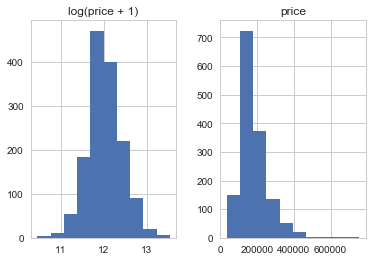

In [51]:
prices = pd.DataFrame({"price":train["SalePrice"], "log(price + 1)":np.log1p(train["SalePrice"])})
prices.hist()

In [52]:
from scipy.stats import skew

all_data = pd.concat((train.loc[:,'MSSubClass':'SaleCondition'],
                      test.loc[:,'MSSubClass':'SaleCondition']))
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index
skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index
skewed_feats

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtHalfBath', 'KitchenAbvGr',
       'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
       'ScreenPorch', 'PoolArea', 'MiscVal'],
      dtype='object')

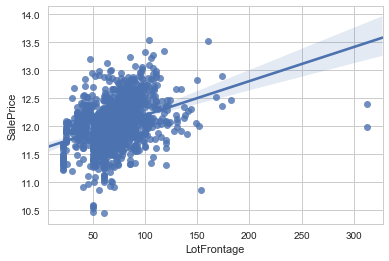

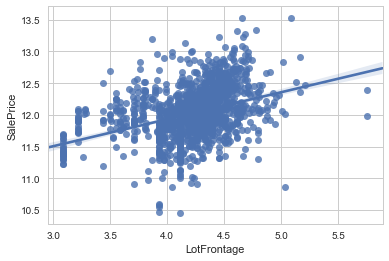

In [53]:
train["SalePrice"] = np.log1p(train["SalePrice"])
LotFrontage = pd.DataFrame({"LotFrontage":train["LotFrontage"], "log(LotFrontage + 1)":np.log1p(train["LotFrontage"])})
sns.regplot(train['LotFrontage'], train['SalePrice'])
plt.show()
plt.clf()
sns.regplot(np.log1p(train["LotFrontage"]), train['SalePrice'])

In [54]:
all_data[skewed_feats] = np.log1p(all_data[skewed_feats])

C:\Anaconda3\envs\deeplearning\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log1p
  """Entry point for launching an IPython kernel.


In [55]:
#creating matrices for sklearn:
X_train = all_data[:train.shape[0]]
X_test = all_data[train.shape[0]:]
y = train.SalePrice

In [56]:
sns.set(style="whitegrid", color_codes=True)

for predictor in train.columns:
    print("plotting: " + predictor)
    print(train[predictor].dtype.name)
    fig, ax = plt.subplots()
    # the size of A4 paper
    f = fig.set_size_inches(11.7, 8.27)
    if train[predictor].dtype.name == "object":
        g = sns.stripplot(x=predictor, y="SalePrice", data=train, ax=ax)
    else:
        g = sns.regplot(x=predictor, y="SalePrice", data=train, ax=ax)
    plt.xticks(rotation=45)
    plt.show()
    plt.clf()

In [58]:
cols = train.columns
num_cols = train._get_numeric_data().columns
num_cols

In [59]:
categoricals = list(set(cols) -  set(num_cols))
categoricals

In [60]:
train['FireplaceQu'].value_counts()

None    690
Gd      380
TA      313
Fa       33
Ex       24
Po       20
Name: FireplaceQu, dtype: int64

In [61]:
X_train = pd.get_dummies(X_train, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)

In [73]:
train.isnull().values.any()

False

In [64]:
train.columns[train.isna().any()].tolist()

In [65]:
X_train.loc[:, X_train.isna().any()]

,MasVnrArea
0,5.214936
1,0.000000
2,5.303305
3,0.000000
4,0.000000
5,0.000000
6,0.000000
7,0.000000
8,5.141664
9,0.000000


In [66]:
X_train = X_train.dropna()
X_test.dropna(inplace=True)
y.drop(axis=0, index = y.index.delete(X_train.index), inplace=True)
print(X_train.shape)
print(y.index.delete(X_train.index))
y.shape

(1456, 355)
Int64Index([17, 263, 369, 1369], dtype='int64')


(1456,)

In [67]:
from xgboost import XGBClassifier
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
X_train, X_test, y_train, y_test = train_test_split(X_train, y, train_size=0.75, test_size=0.25)

def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

def run_model_tester(model, hyperPar=None):
    model.fit(X_train, y_train)
    print("finished fitting")
    y_pred = model.predict(X_test)
    print("finished test predicting")
    predictions = [round(value) for value in y_pred]
    print("got test predictions")
    accuracy = mean_squared_error(y_test, predictions)
    print("test accuracy: " + str(accuracy))
    y_train_pred = model.predict(X_train)
    print("finnished train predicting")
    train_pred = predictions = [round(value) for value in y_train_pred]
    print("got train predictions")
    accuracy_train = mean_squared_error(y_train, train_pred)
    print("train accuracy: " + str(accuracy_train))
    
model = XGBClassifier(silent=False)
run_model_tester(model)

In [68]:
model.get_params

It looks like we might have some overfitting with the above parameters, lets try to play with them to account for this overfitting.
we will:
> - decrease subsample
> - 

In [69]:
subsamples = [0.01, 0.03, 0.05, 0.1, 0.15, 0.3, 0.5, 0.75]
model = XGBClassifier(subsample=0.5, silent=False)
cv = [rmse_cv(XGBClassifier(subsample=subsample, silent=False)).mean() 
            for subsample in subsamples]
cv = pd.Series(cv, index = subsamples)
cv.plot()
run_model_tester(model)

OK, that didnt work, now I have high bias...lets go back to the same subsample.
This time we will try with some more prunning, increase gamma (default is zero).

In [70]:
gammas = [0.05, 0.7, 1, 3, 5, 9, 15]
cv = [rmse_cv(XGBClassifier(gamma=gamma, silent=False)).mean() 
            for gamma in gammas]
cv = pd.Series(cv, index = gammas)
cv.plot()

that did not work either...
perhaps I had high bias at first? (~80% is pretty low...)
lets play with the number of trees

In [71]:
numbers = [1, 5, 15, 25, 50, 90, 150, 200, 250]
cv = [rmse_cv(XGBClassifier(n_estimators=number, silent=False)).mean() 
            for number in numbers]
cv = pd.Series(cv, index = numbers)
cv.plot()

model = XGBClassifier(silent=False, n_estimators=250)
run_model_tester(model)

looks  like the optimum is about 70

In [72]:
model = XGBClassifier(silent=False, n_estimators=70, gamma=0, subsample=1)
mean_cross_root_mse = rmse_cv((model)).mean()
print("mean_coross_root_mse: " + str(mean_cross_root_mse))
run_model_tester(model)

mean_coross_root_mse: 0.254845349273
finished fitting
finished test predicting
got test predictions
test accuracy: 0.125041892642
finnished train predicting
got train predictions
train accuracy: 0.100555859303


In [78]:
model = XGBClassifier(silent=False, n_estimators=70, gamma=0, subsample=1)
y_train = train['SalePrice']
X_train = train.drop(['Id', 'SalePrice'], axis=1)
train_objs_num = len(train)
X_test = test.drop(['Id'], axis=1)
dataset = pd.concat(objs=[X_train, X_test], axis=0)
dataset_preprocessed = pd.get_dummies(dataset)
train_preprocessed = dataset_preprocessed[:train_objs_num]
test_preprocessed = dataset_preprocessed[train_objs_num:]

model.fit(train_preprocessed, y_train)
y_test = model.predict(test_preprocessed)
result = pd.DataFrame();
result['Id'] =  test['Id']
result['SalePrice'] = y_test

In [81]:
result.to_csv('submission.csv', index=False)

In [80]:
submission = pd.read_csv('submission.csv')
print(f'submission shape: {submission.shape}')

submission shape: (1459, 3)


using regular test train and dropping na:

mean_coross_root_mse: 0.228500917516<br>
finished fitting<br>
finished test predicting<br>
got test predictions<br>
test accuracy: 0.147900682467<br>
finnished train predicting<br>
got train predictions<br>
train accuracy: 0.101943189074

using a dest where the  relevant NA were casted to be categories:

mean_coross_root_mse: 0.249941928588<br>
finished fitting<br>
finished test predicting<br>
got test predictions<br>
test accuracy: 0.146362743587<br>
finnished train predicting<br>
got train predictions<br>
train accuracy: 0.106929547729

using data set where all nans were predicted by sgboost:<br>

mean_coross_root_mse: 0.254845349273<br>
finished fitting<br>
finished test predicting<br>
got test predictions<br>
test accuracy: 0.125041892642<br>
finnished train predicting<br>
got train predictions<br>
train accuracy: 0.100555859303<br>

it looks like the cross  validation here is worse but the test accuracy and the train accuracy are better.